In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl
from scipy.spatial import ConvexHull

# our functions
import predict_Beta_I
import choice_start_day
import plot_hyb

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
df_seeds[df_seeds.set!='test']['seed_number'].values

array([   0,    1,    2, ..., 1497, 1498, 1499])

In [4]:
def apply_methods(seed_dirs='initial_data/initial_data_ba_10000/',
                  df_seeds = 'initial_data/seeds_set_parameters.csv',
                 idx_s=0, idx_e=11, n_seeds=1201, show_fig_flag=False,
                 is_filename=False, sigma=0.1, gamma=0.08):
    
    df_seeds = pd.read_csv(df_seeds)
    if is_filename:
        col = 'file'
    else:
        col='seed_number'
        
    seed_numbers = df_seeds[df_seeds.set=='test'][col].values[:n_seeds]

    types_start_day = ['roll_var_npeople']#, 'roll_var', 'roll_var_seq']

    methods = ['last value','rolling mean last value',
               'expanding mean last value','biexponential decay', 

            'median beta', 'regression (day)',

            'median beta;\nshifted forecast',
            'regression (day);\nshifted forecast',
            'regression (day);\nincremental learning',
            'regression (day, SEIR, previous I)','lstm (day, E, previous I)'
              ]

    new_labels = ['last_value', 'rolling_mean_last_value',
            'expanding_mean_last_value','biexponential_decay', 

            'median_beta', 'regression_day',

            'median_beta_shifted_forecast',
            'regression_day_shifted_forecast',
            'regression_day_incremental_learning',
            'regression_day_SEIR_previous_I','lstm_day_E_previous_I'
                 ]

    for type_start_day in types_start_day:

        for beta_pred,new_label in zip(methods[idx_s:idx_e], 
                                       new_labels[idx_s:idx_e]):

            if 'median' in beta_pred:
                model_path = f'{seed_dirs}/median_beta.csv'
            elif 'regression (day)' in beta_pred: 
                model_path = f'{seed_dirs}/regression_day_for_seir.joblib'
            elif '(day, SEIR, previous I)' in beta_pred:
                model_path = f'{seed_dirs}/regression_day_SEIR_prev_I_for_seir.joblib'
            elif 'lstm' in beta_pred:
                model_path = f'{seed_dirs}/lstm_day_E_for_seir'    
            else:
                model_path=''
            print(model_path)
            all_rmse_I, all_rmse_Beta, all_peak, \
                execution_time, start_days = plot_hyb.main_f(I_prediction_method='seir', 
                                    stochastic=False, count_stoch_line=0, 
                                    beta_prediction_method=beta_pred, 
                                    type_start_day=type_start_day, 
                                    seed_numbers=seed_numbers, 
                                    show_fig_flag=show_fig_flag,
                                    seed_dirs=seed_dirs, 
                                    sigma=sigma, gamma=gamma, 
                                    ax=None, model_path=model_path,
                                    is_filename=is_filename)
            # creating a dataframe for peaks
            all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 
                                                       'actual_peak_day', 'predicted_peak_day'])
            # creating a dataframe for peaks RMSE, predicted time, start day
            rmse_df = pd.DataFrame({
                'rmse_I': all_rmse_I,
                'rmse_Beta': all_rmse_Beta,
                'time_predict': execution_time,
                f'{type_start_day}': start_days})

            # merging dataframes
            results = pd.concat([rmse_df, all_peak], axis=1)
            
            if is_filename:
                results.to_csv(f'results/new_ba_10k/{type_start_day}/{new_label}_results.csv', 
                           index=False)
            else:
                ntype, npop = seed_dirs[26:-1].split('_')
                if int(npop) == 10000:
                    npop = ''
                elif int(npop) == 100000:
                    npop = '_100k'
                elif int(npop) == 50000:
                    npop = '_50k'
                results.to_csv(f'results/{ntype+npop}/{type_start_day}/{new_label}_results.csv', 
                           index=False)

In [5]:
def create_boxplots(seed_dirs, type_start_day='roll_var_npeople', 
                    n_seeds=301, is_filename=False):
    methods = [['$\mathregular{M_{last\_val}}$','$\mathregular{M_{ma\_val}}$',
        '$\mathregular{M_{ca\_val}}$','$\mathregular{M_{biexp}}$'], 

        ['$\mathregular{M_{median}}$','$\mathregular{M_{regr}}$'],

        ['$\mathregular{M^{shift}_{median}}$','$\mathregular{M^{shift}_{regr}}$',
        '$\mathregular{M^{add}_{regr}}$','$\mathregular{M_{reg\_ext}}$',    
        '$\mathregular{M_{LSTM}}$'
        ]]
    new_labels = [['last_value','rolling_mean_last_value',
        'expanding_mean_last_value','biexponential_decay'], 

        ['median_beta','regression_day'],

        ['median_beta_shifted_forecast','regression_day_shifted_forecast',
        'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I'
        ]]
    
    switch = type_start_day

    fig = plt.figure(figsize=(12, 4)) 
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.]) 
    
    if not is_filename:
        ntype, npop = seed_dirs[26:-1].split('_')
        if int(npop) == 10000:
            npop = ''
        elif int(npop) == 100000:
            npop = '_100k'
        elif int(npop) == 50000:
            npop = '_50k'
        
    ax_list = []    
    max_list = []
    for i in range(len(methods)):
        
        rmse_df = pd.DataFrame()
        for beta_prediction_method, new_label in zip(methods[i], new_labels[i]):
            # loading data from CSV
            if is_filename:
                df = pd.read_csv(f'results/new_ba_10k/{type_start_day}/{new_label}_results.csv')
            else:
                df = pd.read_csv(f'results/{ntype+npop}/{type_start_day}/{new_label}_results.csv')
            
            # add data to DataFrame with the column name as the method
            rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
            print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
            
        max_list.append(rmse_df.max().max())
        # creating a boxplot
        ax = plt.subplot(gs[i])
        ax_list.append(ax)
        box = ax.boxplot(rmse_df[methods[i]], showfliers=True, 
                          medianprops=dict(color='red',linewidth=1.5), 
                          widths=0.5, patch_artist=True)
        median_c = (1.0, 0.7, 0.7, 0.2)
        lw=1
        for n, patch in enumerate(box['boxes']):
            if (i == 0) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 1) & (n < 1):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 2) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            else:
                patch.set(fill=False)  
        
        ax.set_title(f'RMSE for Infected, group {i+1}')
        if i==1:
            ax.set_xlabel('Methods')
        if i==0:
            ax.set_ylabel('RMSE')
        ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
                labels=methods[i], rotation=0, ha='center', fontsize=13)
        ax.grid()  
        
    for ax in ax_list:
        ax.set_ylim(-50, 1000#np.max(max_list[max_list != np.inf])*1.1
                   ) 
    if is_filename:
        plt.savefig(f'results/new_ba_10k/{switch}/rmse_I_3.pdf', 
            format='pdf', bbox_inches='tight')
    else:
        plt.savefig(f'results/{ntype+npop}/{switch}/rmse_I_3.pdf', 
            format='pdf', bbox_inches='tight')


last value 


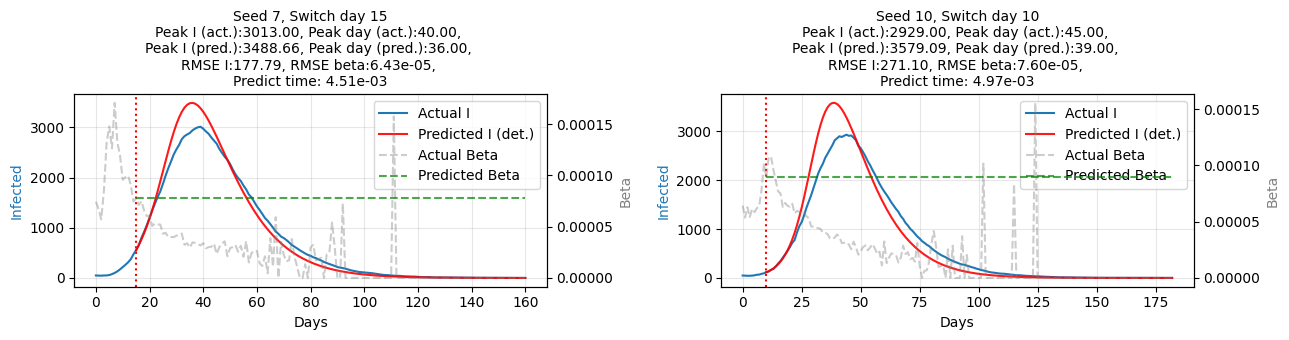


rolling mean last value 


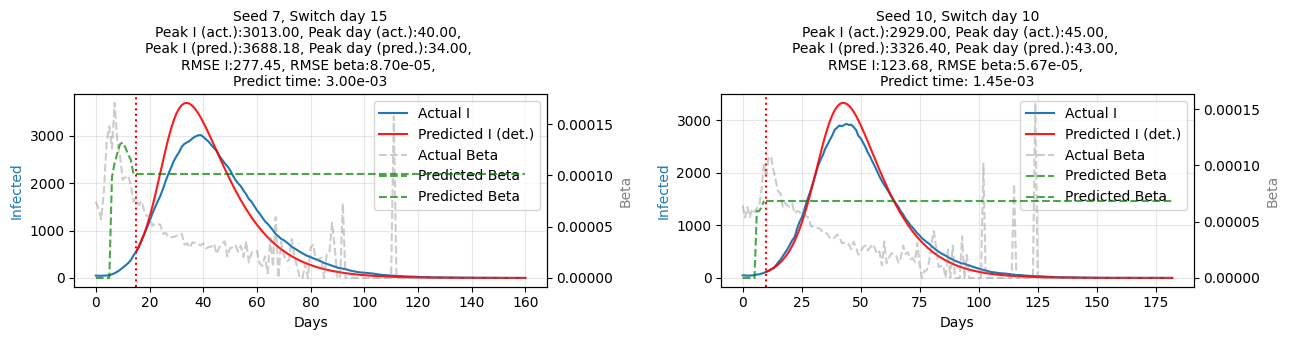


expanding mean last value 


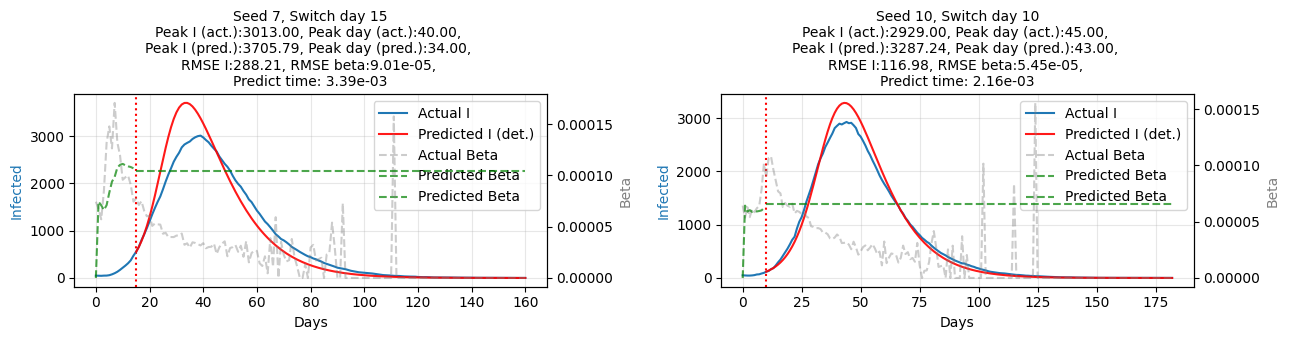


biexponential decay 


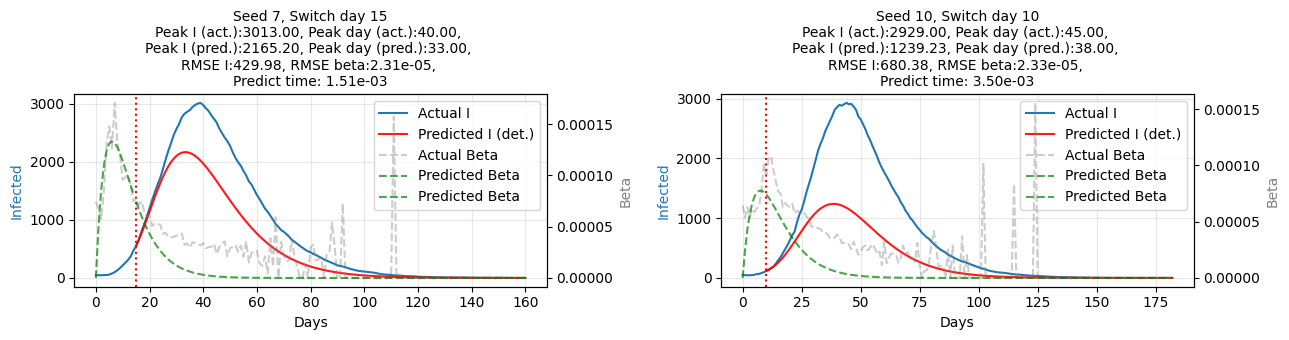

initial_data/initial_data_ba_10000//median_beta.csv
median beta initial_data/initial_data_ba_10000//median_beta.csv


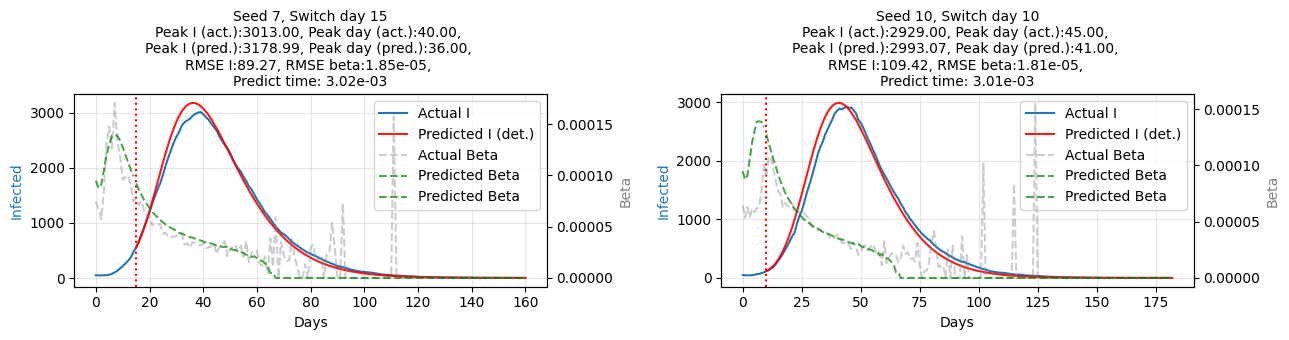

initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day) initial_data/initial_data_ba_10000//regression_day_for_seir.joblib


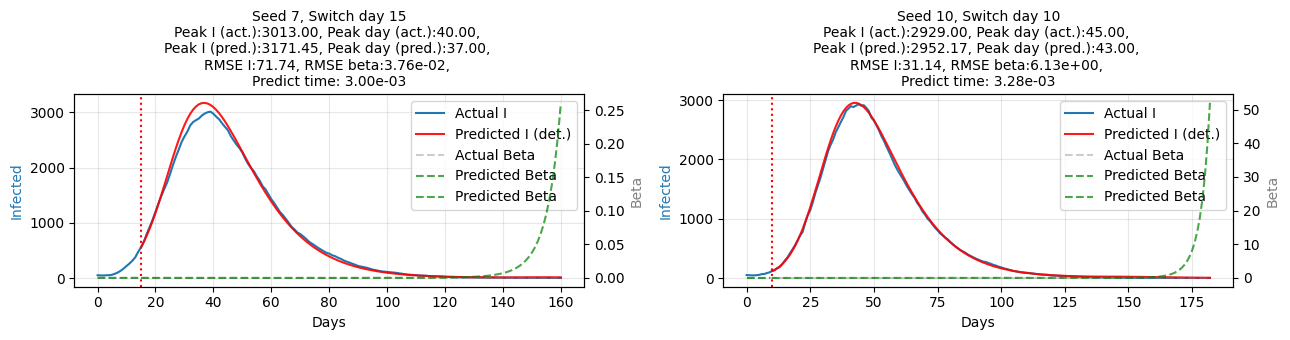

initial_data/initial_data_ba_10000//median_beta.csv
median beta;
shifted forecast initial_data/initial_data_ba_10000//median_beta.csv


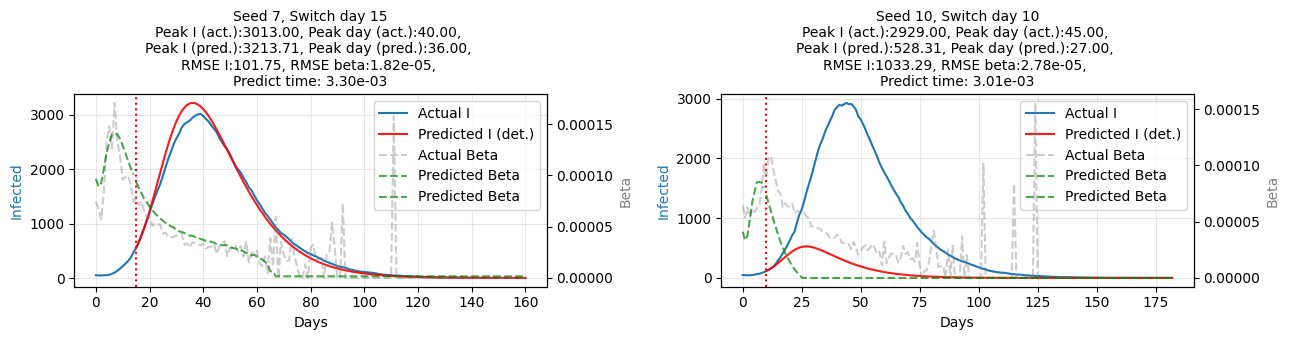

initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day);
shifted forecast initial_data/initial_data_ba_10000//regression_day_for_seir.joblib


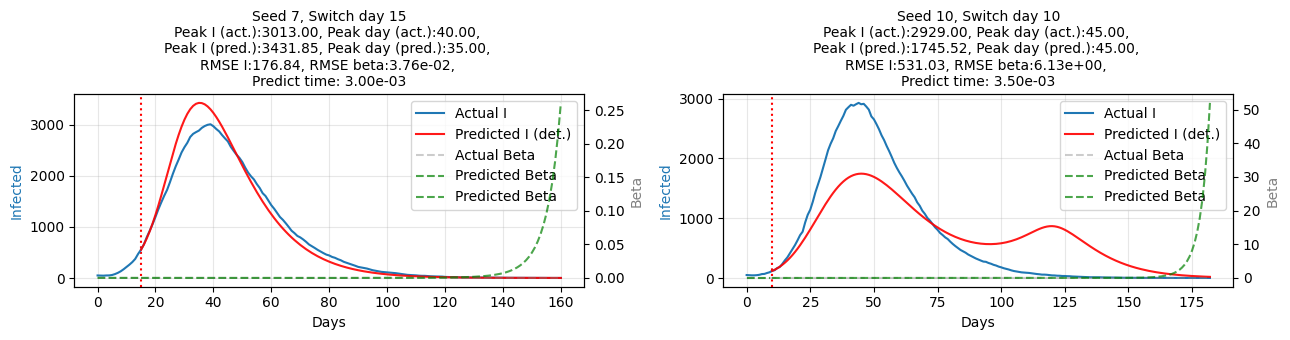

initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day);
incremental learning initial_data/initial_data_ba_10000//regression_day_for_seir.joblib


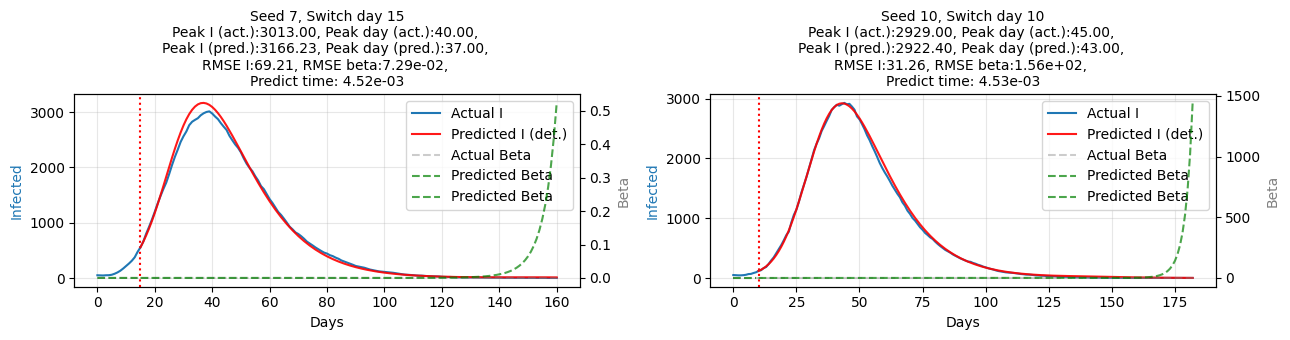

initial_data/initial_data_ba_10000//regression_day_SEIR_prev_I_for_seir.joblib
regression (day, SEIR, previous I) initial_data/initial_data_ba_10000//regression_day_SEIR_prev_I_for_seir.joblib


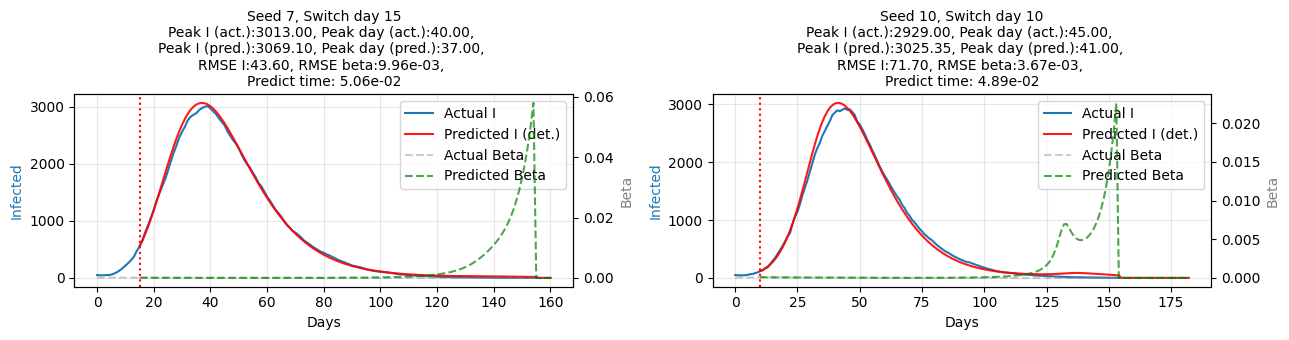

initial_data/initial_data_ba_10000//lstm_day_E_for_seir
lstm (day, E, previous I) initial_data/initial_data_ba_10000//lstm_day_E_for_seir


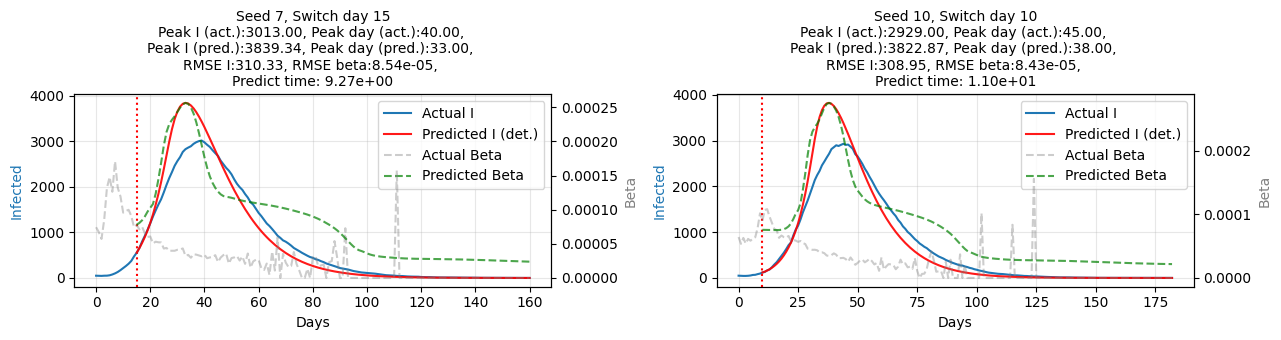

In [10]:
apply_methods(seed_dirs='initial_data/initial_data_ba_10000/',
              df_seeds = 'initial_data/seeds_set_parameters.csv',
              idx_s=0, idx_e=11, n_seeds=2, show_fig_flag=True,
             is_filename=False, sigma=0.1, gamma=0.08)

In [11]:
apply_methods(seed_dirs='initial_data/initial_data_ba_10000/',
              df_seeds = 'initial_data/seeds_set_parameters.csv',
              idx_s=0, idx_e=11, n_seeds=301, show_fig_flag=False,
             is_filename=False, sigma=0.1, gamma=0.08)


last value 

rolling mean last value 

expanding mean last value 

biexponential decay 
initial_data/initial_data_ba_10000//median_beta.csv
median beta initial_data/initial_data_ba_10000//median_beta.csv
initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day) initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
initial_data/initial_data_ba_10000//median_beta.csv
median beta;
shifted forecast initial_data/initial_data_ba_10000//median_beta.csv
initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day);
shifted forecast initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
regression (day);
incremental learning initial_data/initial_data_ba_10000//regression_day_for_seir.joblib
initial_data/initial_data_ba_10000//regression_day_SEIR_prev_I_for_seir.joblib
regression (day, SEIR, previous I) initial_data/initial_data_ba_10000//regression_day_SEI

### new


last value 


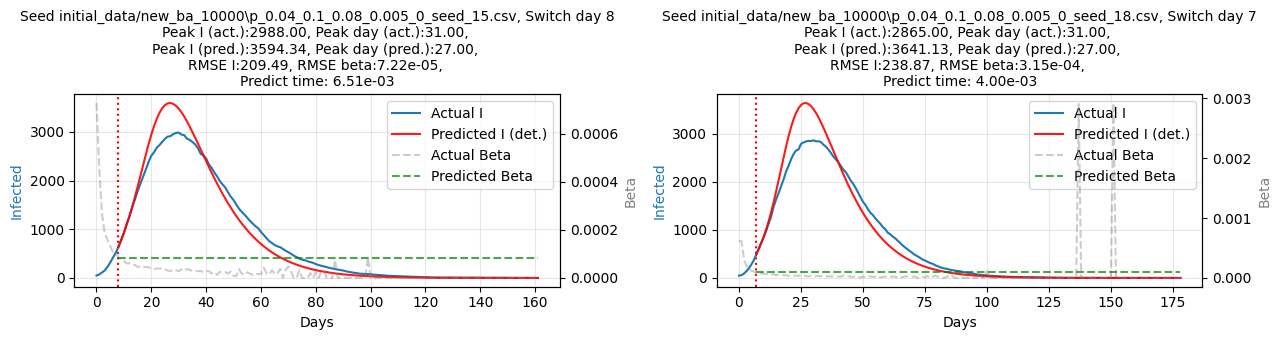


rolling mean last value 


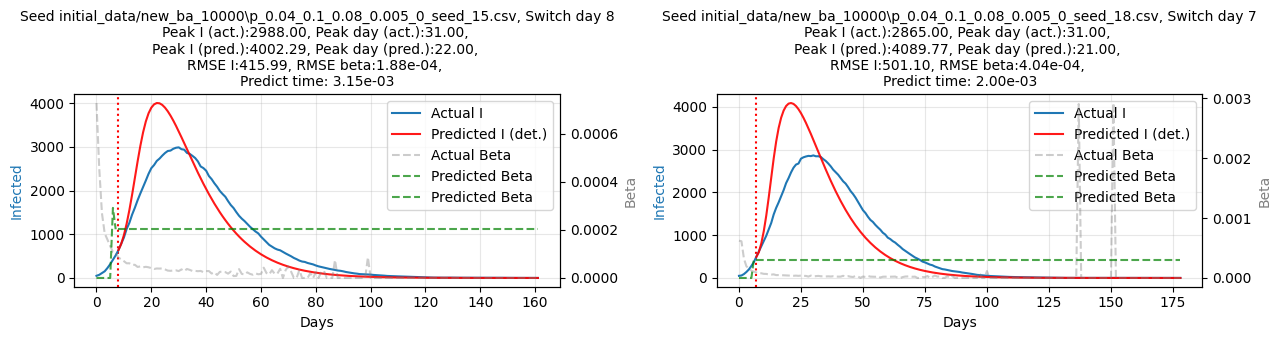


expanding mean last value 


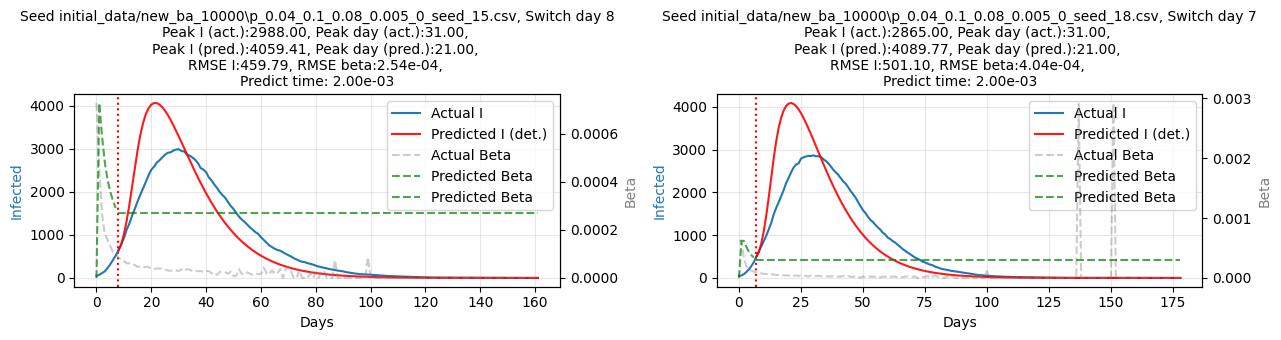


biexponential decay 


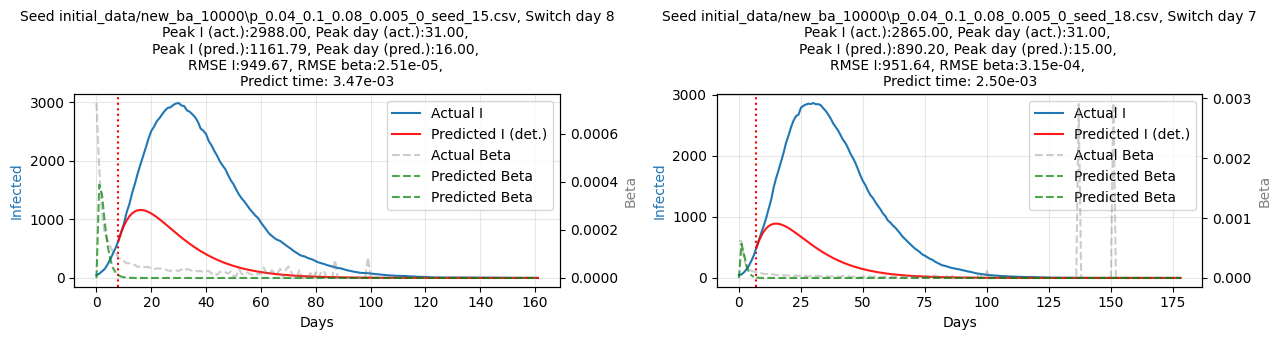

initial_data/new_ba_10000//median_beta.csv
median beta initial_data/new_ba_10000//median_beta.csv


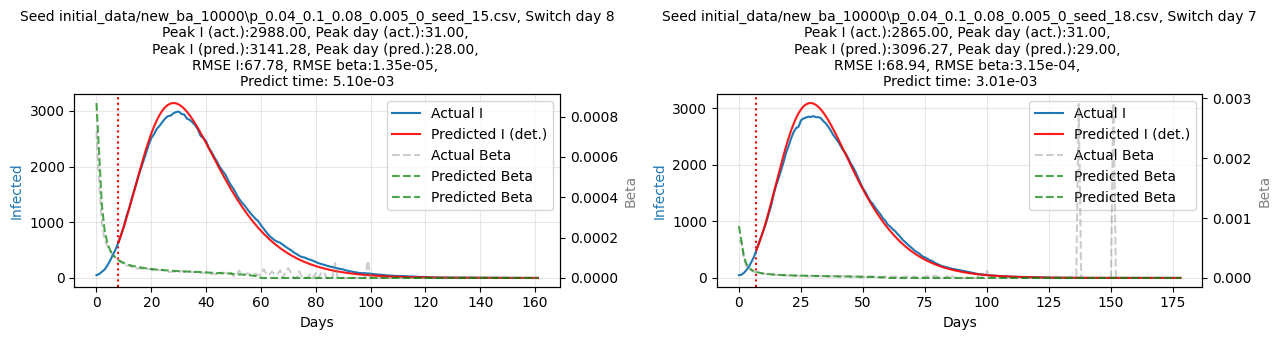

initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day) initial_data/new_ba_10000//regression_day_for_seir.joblib


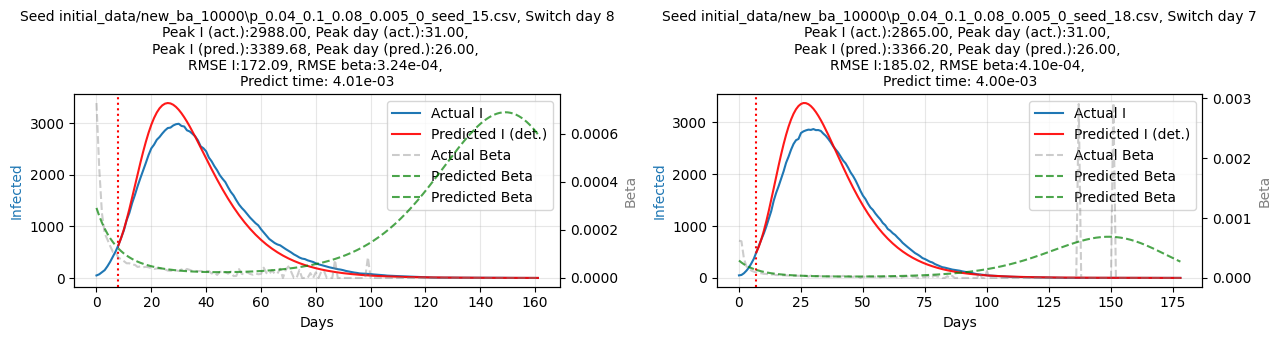

initial_data/new_ba_10000//median_beta.csv
median beta;
shifted forecast initial_data/new_ba_10000//median_beta.csv


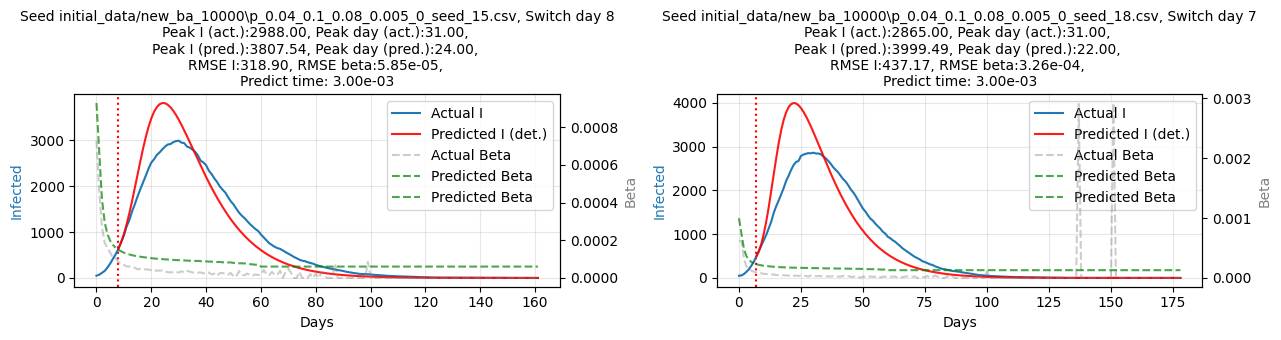

initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day);
shifted forecast initial_data/new_ba_10000//regression_day_for_seir.joblib


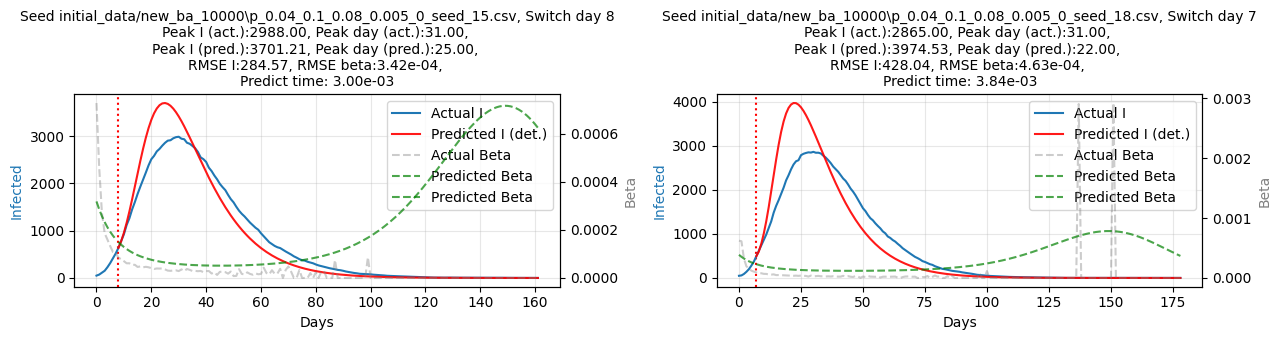

initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day);
incremental learning initial_data/new_ba_10000//regression_day_for_seir.joblib


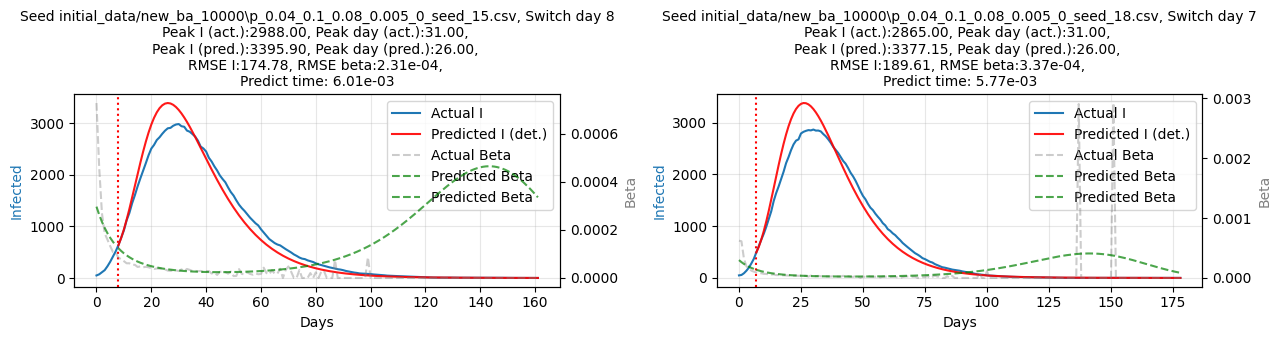

initial_data/new_ba_10000//regression_day_SEIR_prev_I_for_seir.joblib
regression (day, SEIR, previous I) initial_data/new_ba_10000//regression_day_SEIR_prev_I_for_seir.joblib


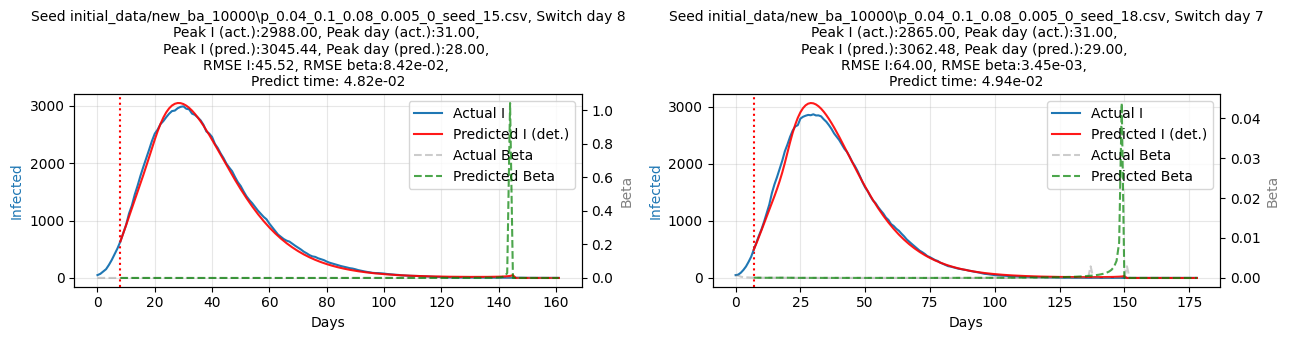

initial_data/new_ba_10000//lstm_day_E_for_seir
lstm (day, E, previous I) initial_data/new_ba_10000//lstm_day_E_for_seir


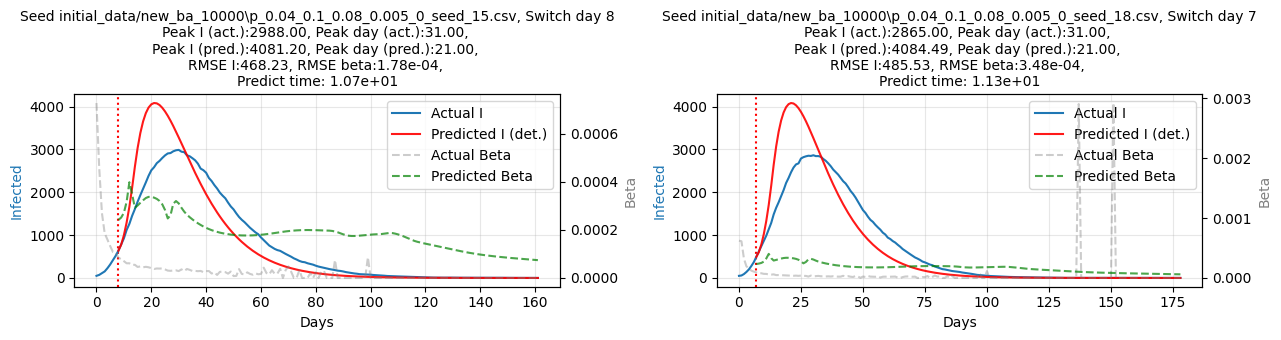

In [16]:
apply_methods(seed_dirs='initial_data/new_ba_10000/',
              df_seeds = 'initial_data/new_seeds_parameters.csv',
              idx_s=0, idx_e=11, n_seeds=2, show_fig_flag=True,
             is_filename=True, sigma=0.1, gamma=0.08)

In [12]:
apply_methods(seed_dirs='initial_data/new_ba_10000/',
              df_seeds = 'initial_data/new_seeds_parameters.csv',
              idx_s=0, idx_e=9, n_seeds=301, show_fig_flag=False,
             is_filename=True, sigma=0.1, gamma=0.08)


last value 

rolling mean last value 

expanding mean last value 

biexponential decay 
initial_data/new_ba_10000//median_beta.csv
median beta initial_data/new_ba_10000//median_beta.csv
initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day) initial_data/new_ba_10000//regression_day_for_seir.joblib
initial_data/new_ba_10000//median_beta.csv
median beta;
shifted forecast initial_data/new_ba_10000//median_beta.csv
initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day);
shifted forecast initial_data/new_ba_10000//regression_day_for_seir.joblib
initial_data/new_ba_10000//regression_day_for_seir.joblib
regression (day);
incremental learning initial_data/new_ba_10000//regression_day_for_seir.joblib


## plot

Median RMSE I for last_value 1564.2432793882526
Median RMSE I for rolling_mean_last_value 1789.487733961084
Median RMSE I for expanding_mean_last_value 1463.954824577468
Median RMSE I for biexponential_decay 1885.8141819654047
Median RMSE I for median_beta 290.3779579385052
Median RMSE I for regression_day 524.8670268021787
Median RMSE I for median_beta_shifted_forecast 836.6097298972213
Median RMSE I for regression_day_shifted_forecast 1298.3854285211635
Median RMSE I for regression_day_incremental_learning 502.03164356422417
Median RMSE I for regression_day_SEIR_previous_I 1116.5060679992416


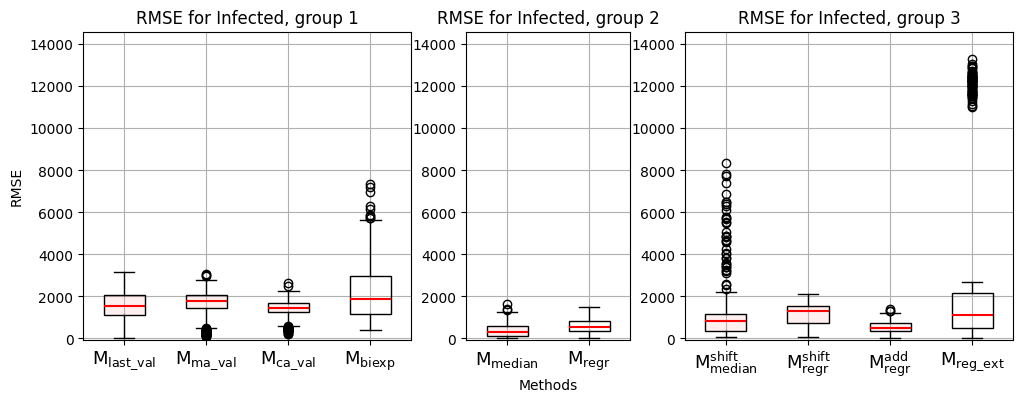

In [66]:
create_boxplots(seed_dirs='initial_data/initial_data_ba_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301)

Median RMSE I for last_value 182.78215233819552
Median RMSE I for rolling_mean_last_value 144.9141639048758
Median RMSE I for expanding_mean_last_value 138.0661673940284
Median RMSE I for biexponential_decay 486.06612379963224
Median RMSE I for median_beta 61.29209581560103
Median RMSE I for regression_day 108.54199980865242
Median RMSE I for median_beta_shifted_forecast 139.9964727532498
Median RMSE I for regression_day_shifted_forecast 118.86370875162942
Median RMSE I for regression_day_incremental_learning 113.3665658609589
Median RMSE I for regression_day_SEIR_previous_I 77.60771000362863
Median RMSE I for lstm_day_E_previous_I 181.52297221548508


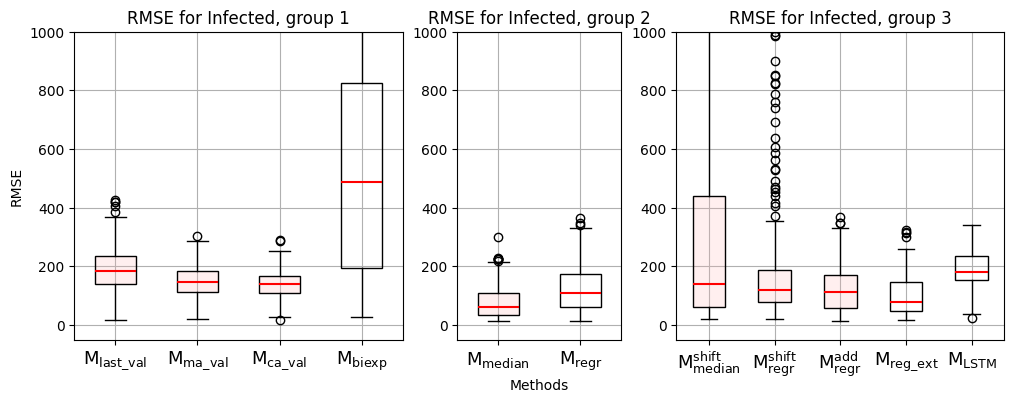

In [15]:
create_boxplots(seed_dirs='initial_data/initial_data_ba_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301)

### new

Median RMSE I for last_value 103.74392906140051
Median RMSE I for rolling_mean_last_value 234.9661294870812
Median RMSE I for expanding_mean_last_value 268.86024583865213
Median RMSE I for biexponential_decay 723.4981725768337
Median RMSE I for median_beta 43.148169698604356
Median RMSE I for regression_day 103.59716944044703
Median RMSE I for median_beta_shifted_forecast 179.77145359430446
Median RMSE I for regression_day_shifted_forecast 163.10450816406694
Median RMSE I for regression_day_incremental_learning 107.2968042162702
Median RMSE I for regression_day_SEIR_previous_I 43.212627398918954
Median RMSE I for lstm_day_E_previous_I 274.7750048715137


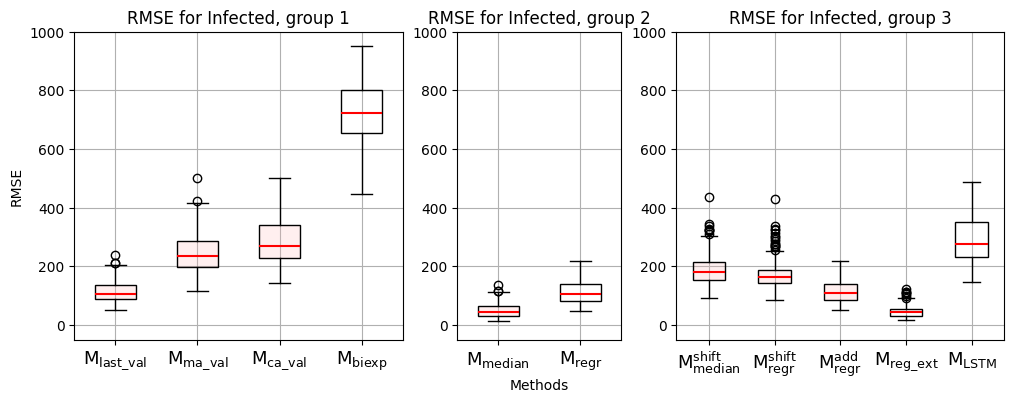

In [16]:
create_boxplots(seed_dirs='initial_data/new_ba_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

In [ ]:
1

## peaks

In [115]:
def create_peak_plot(folder = 'new_ba_10k', switch = 'roll_var_npeople',
                    with_outliers=True, same_lims=False):
    fig, axes = plt.subplots(1,3, figsize=(11, 4))
    axes = axes.flatten()

    x_lim = (-130, 20)
    y_lim = (0.6, 2.3)
    size_m=120
    alpha_m=0.4
    alpha_area=0.35
    
    ax = axes[0]

    all_methods = [['$\mathregular{M_{last\_val}}$',
               '$\mathregular{M_{ca\_val}}$',
              '$\mathregular{M_{ma\_val}}$',
              '$\mathregular{M_{biexp}}$'],
               
               ['$\mathregular{M_{regr}}$',
               '$\mathregular{M_{median}}$'],
               
               ['$\mathregular{M^{shift}_{regr}}$',
               '$\mathregular{M^{shift}_{median}}$',
                '$\mathregular{M^{add}_{regr}}$',
                '$\mathregular{M_{LSTM}}$',
                '$\mathregular{M_{reg\_ext}}$']]
    
    all_new_labels = [['last_value','rolling_mean_last_value',
                  'expanding_mean_last_value',
                  'biexponential_decay'],
                  
                  ['regression_day', 'median_beta'],
                  
                  ['regression_day_shifted_forecast',
                  'median_beta_shifted_forecast',
                    'regression_day_incremental_learning',
                    'lstm_day_E_previous_I',
                    'regression_day_SEIR_previous_I']]
    
    
    ymin, ymax, xmin, xmax = 100, -100, 100, -100          
    for i, sub_methods, sub_labels in zip(np.arange(3), 
                                          all_methods, all_new_labels):
        plot_peaks_ax(axes[i], sub_methods, sub_labels, folder, switch,
                     x_lim, y_lim, size_m, alpha_m, alpha_area,
                     with_outliers)
        if same_lims:
            ymin = np.min([ymin, axes[i].get_ylim()[0]])
            ymax = np.max([ymax, axes[i].get_ylim()[1]])
            xmin = np.min([xmin, axes[i].get_xlim()[0]])
            xmax = np.max([xmax, axes[i].get_xlim()[1]])
            
    if same_lims:        
        for i in np.arange(3):
            axes[i].set_xlim(xmin, xmax)
            axes[i].set_ylim(ymin, ymax)

    plt.tight_layout()
    '''
    plt.savefig(f'results/{switch}/peaks_area.pdf', 
                format='pdf', bbox_inches='tight')'''

In [54]:
def find_outliers(vals):
    iqr = np.quantile(vals, .75) - np.quantile(vals, .25)
    l_out = np.quantile(vals, .25) - 1.5 * iqr
    h_out = np.quantile(vals, .75) + 1.5 * iqr
    
    vals_idx = vals[(l_out<vals)&(vals<h_out)].index
    
    return vals_idx, l_out, h_out

In [91]:
def plot_peaks_ax(ax, methods, new_labels, folder, switch,
                 x_lim = (-130, 20), y_lim = (0.6, 2.3), size_m=120,
                  alpha_m=0.4, alpha_area=0.35, with_outliers=True):
    ax.axvline(x=0, color='black', linestyle='--', 
               linewidth=1)
    ax.axhline(y=1, color='black', linestyle='--', 
               linewidth=1)
    
    cmap = mpl.colormaps['Set2']
    colors_l = cmap(np.linspace(0, 1, 8))
    colors = list(colors_l)[:len(methods)]
    
    for name, method in zip(new_labels, methods):
        p_df = pd.read_csv(f'results/{folder}/{switch}/{name}_results.csv')
        pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
        ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
        
        if not with_outliers:
            ph_idx, l_ph, h_ph = find_outliers(ph)
            pt_idx, l_pt, h_pt = find_outliers(pt)
            clean = list(set(ph_idx).intersection(pt_idx))
            ph = ph.loc[clean]
            pt = pt.loc[clean]
        
        hull = ConvexHull(pd.concat([pt,ph], axis=1))

        col = colors.pop()
        ax.scatter(pt,ph, marker='.', s=size_m,  alpha=alpha_m, 
                   label=method, zorder=10, color=col)

        ax.fill(pt.iloc[hull.vertices], 
                 ph.iloc[hull.vertices], alpha=alpha_area, color=col)

    ax.grid()
    ax.set_xlabel('Peak time difference')
    #ax.set_xlim(x_lim)
    #ax.set_ylim(y_lim)

    leg = ax.legend(prop={'size': 13}, loc='best')
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    leg.set_zorder(20)

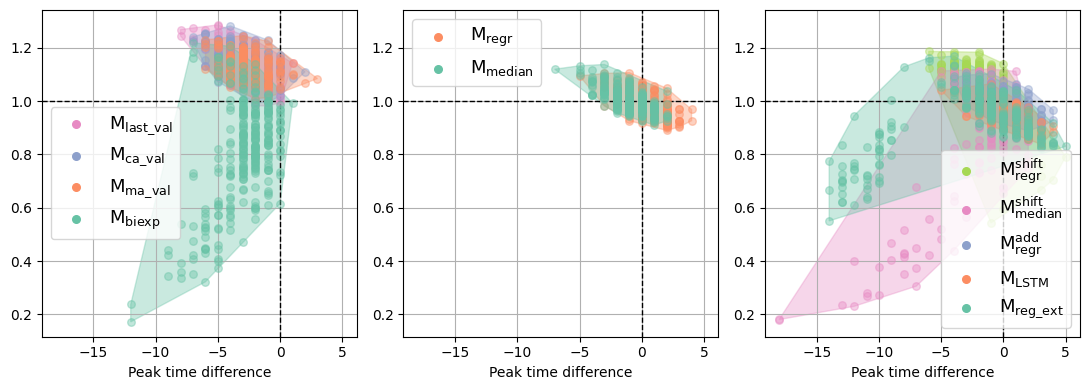

In [121]:
create_peak_plot(folder = 'ba', switch = 'roll_var_npeople', 
                 with_outliers=True, same_lims=True)

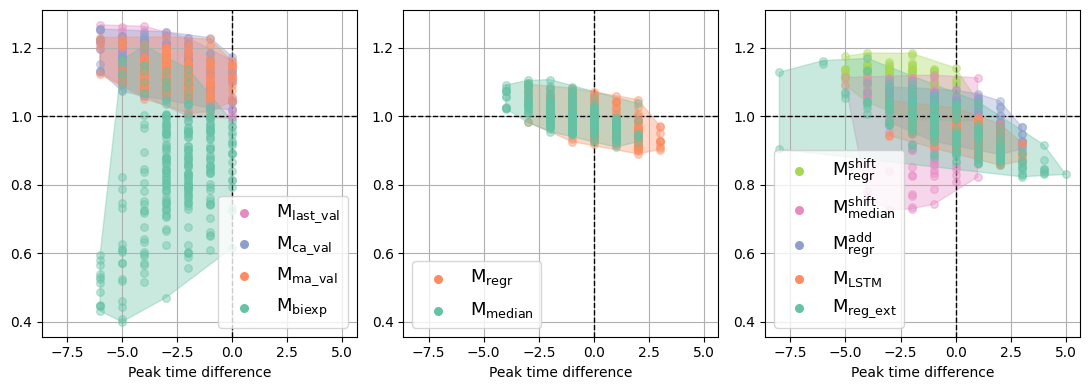

In [122]:
create_peak_plot(folder = 'ba', switch = 'roll_var_npeople', 
                 with_outliers=False, same_lims=True)

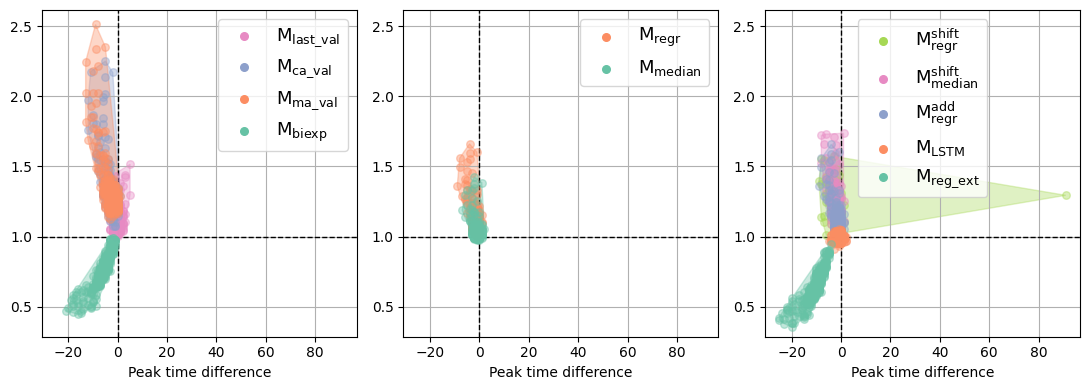

In [123]:
create_peak_plot(folder = 'new_ba_10k', switch = 'roll_var_npeople',
                with_outliers=True, same_lims=True)

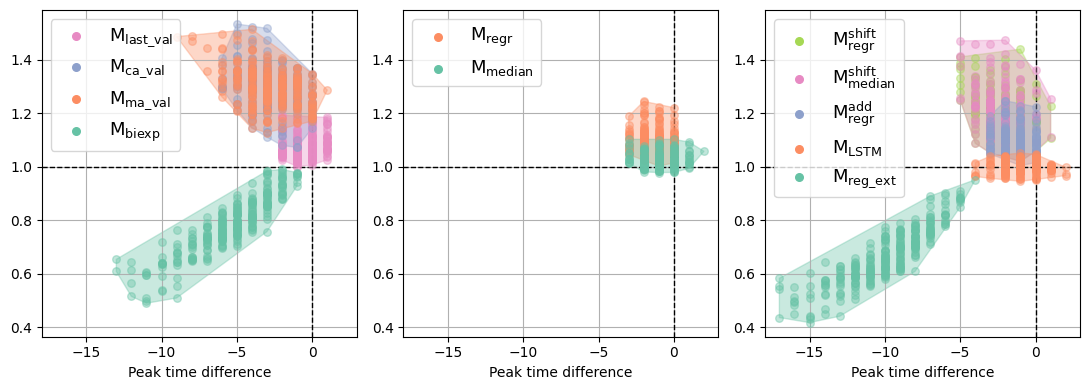

In [124]:
create_peak_plot(folder = 'new_ba_10k', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)